In [3]:
from seagul.rl.ars.ars_pipe import ars
from seagul.nn import MLP
import torch
import matplotlib.pyplot as plt
from seagul.mesh import create_mesh, variation_dim, mesh_dim, BylMesh
import time
import copy
import gym


import xarray as xr
import numpy as np
import pandas as pd

import os

from sklearn.decomposition import PCA

In [4]:
def identity(rews,obs,acts):
    return rews

def vardiv(rews, obs, acts):
    return rews/variation_dim(obs)

def varmul(rews, obs, acts):
    return rews*variation_dim(obs)

def rough_measure(x):
    d = torch.stack([x[t,:] - x[t-1,:] for t in range(1,x.shape[0])])
    return d.std()#$/(torch.abs(d.mean()))

def rmul(rews, obs, acts):
    return rews*rough_measure(obs)

def rdiv(rews, obs, acts):
    return rews/rough_measure(obs)

def do_rollout(env, policy, render=False):
    torch.autograd.set_grad_enabled(False)

    act_list = []
    obs_list = []
    rew_list = []

    dtype = torch.float32
    obs = env.reset()
    done = False
    cur_step = 0

    while not done:
        obs = torch.as_tensor(obs, dtype=dtype).detach()
        obs_list.append(obs.clone())

        act = policy(obs)
        obs, rew, done, _ = env.step(act.numpy())
        if render:
            env.render()
            input("step?")
            #time.sleep(.05)

        act_list.append(torch.as_tensor(act.clone()))
        rew_list.append(rew)

        cur_step += 1

    ep_length = len(rew_list)
    ep_obs = torch.stack(obs_list)
    ep_act = torch.stack(act_list)
    ep_rew = torch.tensor(rew_list, dtype=dtype)
    ep_rew = ep_rew.reshape(-1, 1)

    torch.autograd.set_grad_enabled(True)
    return ep_obs, ep_act, ep_rew, ep_length


def do_long_rollout(env, policy, ep_length):
    torch.autograd.set_grad_enabled(False)

    act_list = []
    obs_list = []
    rew_list = []

    dtype = torch.float32
    obs = env.reset()
    done = False
    cur_step = 0

    while cur_step < ep_length:
        obs = torch.as_tensor(obs, dtype=dtype).detach()
        obs_list.append(obs.clone())

        act = policy(obs)
        obs, rew, done, _ = env.step(act.numpy())

        act_list.append(torch.as_tensor(act.clone()))
        rew_list.append(rew)

        cur_step += 1

    ep_length = len(rew_list)
    ep_obs = torch.stack(obs_list)
    ep_act = torch.stack(act_list)
    ep_rew = torch.tensor(rew_list, dtype=dtype)
    ep_rew = ep_rew.reshape(-1, 1)

    torch.autograd.set_grad_enabled(True)
    return ep_obs, ep_act, ep_rew, ep_length

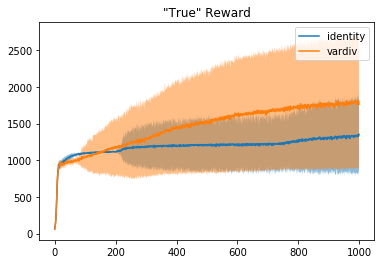

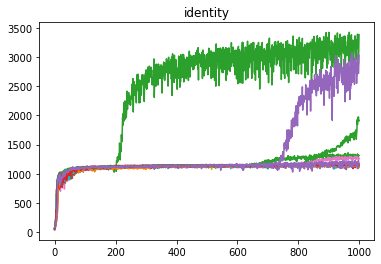

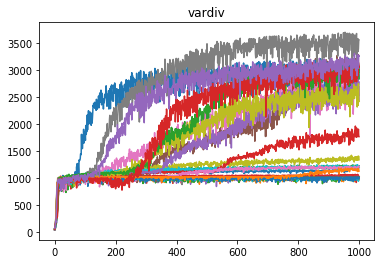

<Figure size 432x288 with 0 Axes>

In [5]:
data = torch.load("./data5/Hopper-v2.xr")

policy_dict = data.policy_dict
rews = data.rews
exp_names = [fn.__name__ for fn in data.attrs['post_fns']]
num_seeds = len(policy_dict['identity'])

#policy_dict = torch.load("./data/mjw_longermul.pol_dict")
#rews = torch.load("./data/mjw_longermul.data")

means = rews.mean(dim="trial")
stds = rews.std(dim="trial")

plt.plot(means.T)
plt.legend(exp_names)
ci = stds

for mean, c in zip(means, ci):
    plt.fill_between([t for t in range(len(mean))], (mean-c), (mean+c), alpha=.5)
plt.title("\"True\" Reward")
plt.figure()

for exp_name in exp_names:  
    plt.plot(rews.loc[exp_name].T)
    plt.title(exp_name)
    plt.figure()

running build_ext
cycles found:  14.0
tensor([3421.1477])


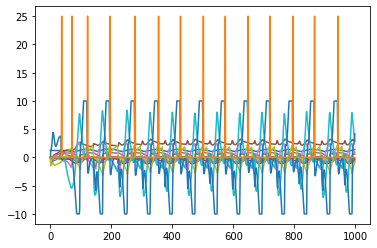

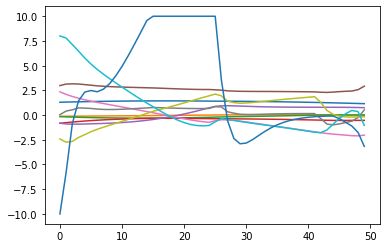

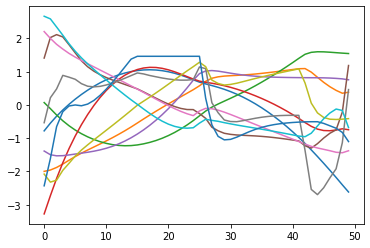

In [6]:
from sklearn.decomposition import PCA
env_name = "Hopper-v2"

policy = policy_dict['vardiv'][5]

env = gym.make(env_name)
obs,acts,rews,l = do_long_rollout(env, policy, ep_length= 1000)
#o,a,r,l = do_rollout(env, policy, render=True)

on = np.zeros(obs.shape[0])
for i,o in enumerate(obs):
    on[i] =  (o[4] > .5 and o[10] < 0.0 and last_o[10] > 0.0)
    last_o = copy.deepcopy(o)

print("cycles found: ", sum(on))

start_idx = 400; end_idx = 450
plt.plot(obs)
plt.plot(on*25)
plt.figure()
plt.plot(obs[start_idx:end_idx])
plt.figure()
ref = np.array(obs[start_idx:end_idx],dtype=np.float64)
target = (ref - ref.mean(axis=0))/ref.std(axis=0)
target = copy.deepcopy(target) # Don't even ask
plt.plot(target)

pca = PCA(n_components=5, svd_solver='arpack')
pca.fit(target)

print(sum(rews))

In [82]:
dl = []
last_seen = 0
for i,o in enumerate(on):
    if o == 1:
        dl.append(i-last_seen)
        last_seen = i
        
dd = {}
for d in dl:
    if (d) in dd: 
        dd[(d)] += 1
    else:
        dd[(d)] = 1
        
for thing in dd.items():
    print("spacing: ", thing[0], " frequency: ", thing[1])

spacing:  39  frequency:  1
spacing:  31  frequency:  1
spacing:  50  frequency:  1
spacing:  75  frequency:  3
spacing:  82  frequency:  1
spacing:  78  frequency:  1
spacing:  72  frequency:  3
spacing:  73  frequency:  1
spacing:  71  frequency:  1
spacing:  76  frequency:  1


In [6]:
np.cumsum(pca.explained_variance_ratio_)

array([0.47244779, 0.85088188, 0.91331083, 0.97509384, 0.98564849])

In [8]:
# Hopper-v2
def hopper_snapshot(o, last_o, step):
    #return (o[3] < -.5 and o[9] > 0.0 and last_o[9] < 0.0 and step > 10)
    return (o[4] > .5 and o[10] < 0.0 and last_o[10] > 0.0 and step > 10)


def hopper_reset(env, point):
    env.reset()
    qpos = np.concatenate((np.array([0.0]), point[:5]))
    qvel = point[5:]
    env.unwrapped.set_state(qpos, qvel)
    return env.unwrapped._get_obs()

def hopper_interp(o, last_o):
    m = o[10] - last_o[10]
    b = last_o[10]
    tcross = -b/m
    return last_o + tcross*(o - last_o)
  

In [10]:
from seagul.mesh import create_mesh_act

perts =  np.random.uniform(-5,5,(25,3))
#perts = np.zeros((100,17))

o = env.reset()
last_o = copy.copy(o)

step = 0
done=False
ol = [] 
while not done:
    a = policy(o).detach(); step+=1
    o, r, done, _ = env.step(a.numpy())
    if hopper_snapshot(o, last_o, step) and step > 200:
        seed_point = o
        done=True
    last_o = copy.copy(o)

print(seed_point)
mesh, mesh_points, T = create_mesh_act(env, policy, .05, seed_point, perts, hopper_reset, hopper_snapshot, hopper_interp, ref.mean(axis=0), ref.std(axis=0))

[ 1.42281474  0.01758744 -0.21873716 -0.30327864  0.94817442  2.41682342
 -0.31363566  0.39706249  1.34392307 -0.18167484 -0.42201492]
explored:  160 | added:  706 | ratio:  0.22662889518413598 | failures:  1 | count:  4000
explored:  200 | added:  974 | ratio:  0.2053388090349076 | failures:  1 | count:  5000
explored:  400 | added:  2241 | ratio:  0.178491744756805 | failures:  1 | count:  10000
explored:  480 | added:  2759 | ratio:  0.17397607828923523 | failures:  1 | count:  12000
explored:  800 | added:  4600 | ratio:  0.17391304347826086 | failures:  1 | count:  20000
explored:  1080 | added:  6002 | ratio:  0.17994001999333556 | failures:  1 | count:  27000
explored:  1320 | added:  7317 | ratio:  0.18040180401804018 | failures:  1 | count:  33000
explored:  1600 | added:  8844 | ratio:  0.18091361374943465 | failures:  1 | count:  40000
explored:  1680 | added:  9314 | ratio:  0.18037363109297833 | failures:  1 | count:  42000
explored:  2040 | added:  11580 | ratio:  0.17616

KeyboardInterrupt: 

In [47]:
failure_point = np.ones_like(seed_point)*10
print(mesh[failure_point].freq)
print(len(mesh))
print(len(mesh_points))

In [68]:
import os
save_name = ""

os.makedirs(f"meshes/{save_name}/", exist_ok=False)
torch.save(mesh, f"meshes/{save_name}/{save_name}.mesh")
torch.save(mesh_points, f"meshes/{save_name}/{save_name}.points")
torch.save(T, f"meshes/{save_name}/{save_name}.T")
torch.save(perts, f"meshes/{save_name}/{save_name}.P")

In [71]:
from scipy import sparse 
Ts = sparse.lil_matrix((T.shape[0], T.shape[0]))
for i,t in enumerate(T):
    #print(i)
    for e in t:
        Ts[i,e] += 1/len(t)
    

In [76]:
w,v = sparse.linalg.eigs(Ts,k=2)

In [77]:
w

array([6.45050015e+16+1.89381864e+17j, 6.45050015e+16-1.89381864e+17j])

0.0

In [12]:
#torch.save(mesh, "hopper_mesh")
#torch.save(mesh_points, "hopper_mesh_points")
#torch.save(T, "hopper_T")